# Pipeline for High-z Radio Galaxies 04: Redshift prediction on radio AGN

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done with AGN from the Million Quasar Catalog (MQC) and QSO from SDSS DR16.  
Only sources with confirmed $z$ will be used.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
import cmasher as cmr
from pycaret import regression as pyr
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

Methods to create values of metrics by redshift ranges

In [4]:
def z_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output  = np.zeros_like(z_range)
    true_vals      = metricArgs[0]
    predicted_vals = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        metric_output[count] = metric_function(sub_set.loc[:, true_vals], sub_set.loc[:, predicted_vals])
    return metric_output

Method to plot metrics

In [5]:
def plot_metric_over_z(z_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(z_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ##
    ax_pre.set_xlabel('$z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq z)$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title, fontsize=14)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

***

## Reading data

In [6]:
save_plot_flag  = False
save_model_flag = False
read_idx_flag   = True
load_model_flag = True
use_calibration = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [7]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 
                      'TYPE', 'Sint_LOFAR', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [8]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [9]:
full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'LOFAR_detect'].astype(int)

In [10]:
# full_catalog_df.describe()

#### Select only confirmed radio AGN

In [11]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, {n_is_gal:,} have been indentified as galaxies,' +\
      f' and {n_is_rad:,} are identified as radio detections (in LOFAR).')

In this dataset, with 15,136,878 elements,
54,519 of them are marked as AGN, 103,964 have been indentified as galaxies, and 342,831 are identified as radio detections (in LOFAR).


In [12]:
target_feat = 'Z'

---

Combine redshift values (AGN + galaxies).

In [13]:
idx_non_Z                = full_catalog_df.loc[:, target_feat].where(full_catalog_df.loc[:, target_feat] > 0).isna()
full_catalog_df.loc[idx_non_Z, target_feat] = full_catalog_df.loc[:, target_feat].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

---

## Possible correlations

In [14]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'spCl', 'band_num', 'LOFAR_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`is_AGN == 1` and `radio_detect == 1`).

In [15]:
filter_known_spec  = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
filter_known_radio = full_catalog_df.loc[:, 'LOFAR_detect'] == 1
full_catalog_df    = full_catalog_df.loc[filter_known_spec]
if not read_idx_flag:
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   'is_AGN', use_calibration=use_calibration)

if read_idx_flag:
    known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt')
    train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt')
    train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt')  # in the future, fix naming
    validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt')  # in the future, fix naming
    calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt')
    test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt')
    
    train_test_df  = full_catalog_df.loc[train_validation_idx]
    train_df       = full_catalog_df.loc[train_idx]
    test_df        = full_catalog_df.loc[validation_idx]
    calibration_df = full_catalog_df.loc[calibration_idx]
    validation_df  = full_catalog_df.loc[test_idx]
    
print('Shape of used data in HETDEX')
print('-' * 65)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 65)
print()

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (158483, 88)
Data for Modeling (Train, Test, and Calibration): (126786, 88)
Training data:                                    (101428, 88)
Testing data:                                     (12679, 88)
Calibration data:                                 (12679, 88)
Validation data:                                  (31697, 88)
-----------------------------------------------------------------



In [16]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) & (full_catalog_df.loc[:, 'LOFAR_detect'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'is_AGN'] == 1) & (train_test_df.loc[:, 'LOFAR_detect'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'is_AGN'] == 1) & (train_df.loc[:, 'LOFAR_detect'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'is_AGN'] == 1) & (test_df.loc[:, 'LOFAR_detect'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'is_AGN'] == 1) & (calibration_df.loc[:, 'LOFAR_detect'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'is_AGN'] == 1) & (validation_df.loc[:, 'LOFAR_detect'] == 1)]

In [17]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed LOFAR radio detection.')

In this dataset (HETDEX), with 8,374 elements,
8,374 of them are marked as AGN, and, from them, 8,374 have confirmed LOFAR radio detection.


Remove intermediate targets

In [18]:
cols_discard_class = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'LOFAR_detect', 'zsp']
full_catalog_df    = full_catalog_df.drop(columns=cols_discard_class)
train_test_df      = train_test_df.drop(columns=cols_discard_class)
train_df           = train_df.drop(columns=cols_discard_class)
test_df            = test_df.drop(columns=cols_discard_class)
calibration_df     = calibration_df.drop(columns=cols_discard_class)
validation_df      = validation_df.drop(columns=cols_discard_class)

---

In [19]:
print('Final shape of used data')
print('-' * 50)
print('Confirmed Radio AGN')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
Confirmed Radio AGN
--------------------------------------------------
Full confirmed dataset size:        (8374, 80)
Data for Modeling (Train and Test): (6679, 80)
Training data:                      (5312, 80)
Testing data:                       (669, 80)
Calibration data:                   (698, 80)
Validation data:                    (1695, 80)
--------------------------------------------------


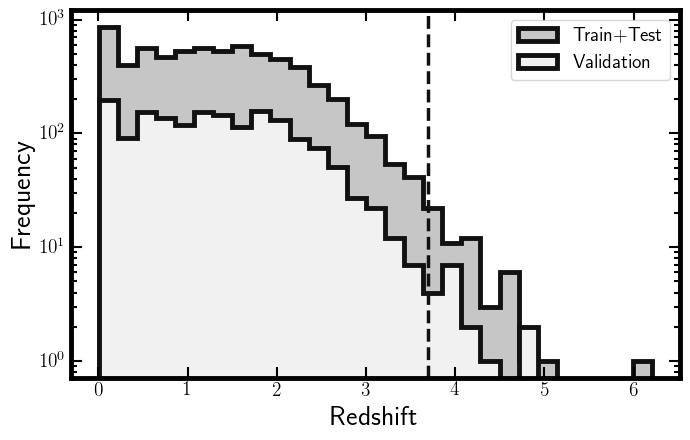

In [20]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, target_feat])
max_score  = np.nanmax(full_catalog_df.loc[:, target_feat])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=3.7, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [21]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [22]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [23]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [24]:
rsd_vals

z_y         308.422922
i_z         265.142028
K_W3        211.431845
i_y         170.252234
r_i         143.207043
W1_W2       134.412872
g_r         117.662047
r_z         113.491933
r_y         108.952993
g_i          98.387733
g_z          89.505570
g_y          88.231793
H_W3         70.573493
Z            66.721177
y_W1         64.789605
z_W1         57.994981
J_W3         57.168744
y_W2         55.202320
i_W1         54.215466
r_W1         54.011330
g_W1         53.620847
y_J          52.362729
z_W2         48.666336
z_J          47.701098
y_H          47.012593
i_J          45.700516
i_W2         45.367900
r_W2         43.880474
z_H          43.121734
r_J          42.996428
g_W2         42.940593
i_H          41.615805
W1_W3        40.492868
W2_W3        40.387769
y_K          40.379119
g_J          40.288879
r_H          39.567667
g_H          37.571475
z_K          37.502053
i_K          36.492589
J_H          35.944642
H_K          35.246468
r_K          34.744004
g_K        

In [25]:
correlation = norm_train_test_df.corr()

In [26]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [27]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [28]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [29]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [30]:
list_drop_corr

['g_H',
 'r_H',
 'y_H',
 'i_H',
 'J_W1',
 'z_H',
 'J_W2',
 'J_W3',
 'Jmag',
 'g_K',
 'J_W4',
 'y_K',
 'r_K',
 'i_K',
 'H_W1',
 'z_K',
 'H_W2',
 'Kmag',
 'W2mproPM',
 'zmag',
 'K_W1',
 'rmag',
 'r_W4',
 'i_W4',
 'H_W3',
 'W2_W4',
 'W1mproPM',
 'r_J',
 'i_J',
 'g_W2',
 'gmag',
 'imag',
 'ymag',
 'z_W4',
 'r_W3',
 'g_W4',
 'W1_W4',
 'i_W3',
 'J_K',
 'y_W4',
 'z_J',
 'g_W1',
 'H_W4',
 'r_W2',
 'r_W1',
 'W2_W3',
 'z_W3',
 'i_W2',
 'i_W1',
 'y_W2',
 'z_W2',
 'W3mag',
 'Hmag',
 'g_z',
 'g_W3',
 'g_y',
 'g_i',
 'z_W1',
 'y_W3',
 'K_W2',
 'W3_W4',
 'r_y']

In [31]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [32]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [33]:
corr_discard = norm_train_test_discard.corr()

In [34]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
g_J       y_J         0.746512
y_J       band_num    0.724855
K_W3      W4mag       0.713318
          K_W4        0.697713
i_y       z_y         0.681717
W1_W3     Z           0.647230
band_num  H_K         0.632703
r_i       r_z         0.625159
W1_W3     y_J         0.618290
i_z       r_z         0.599627
band_num  W1_W3       0.597781
K_W4      W4mag       0.596190
K_W3      y_J         0.561481
H_K       W1_W2       0.551321
dtype: float64

Text(1052.0930609538775, 0.5, 'feature')

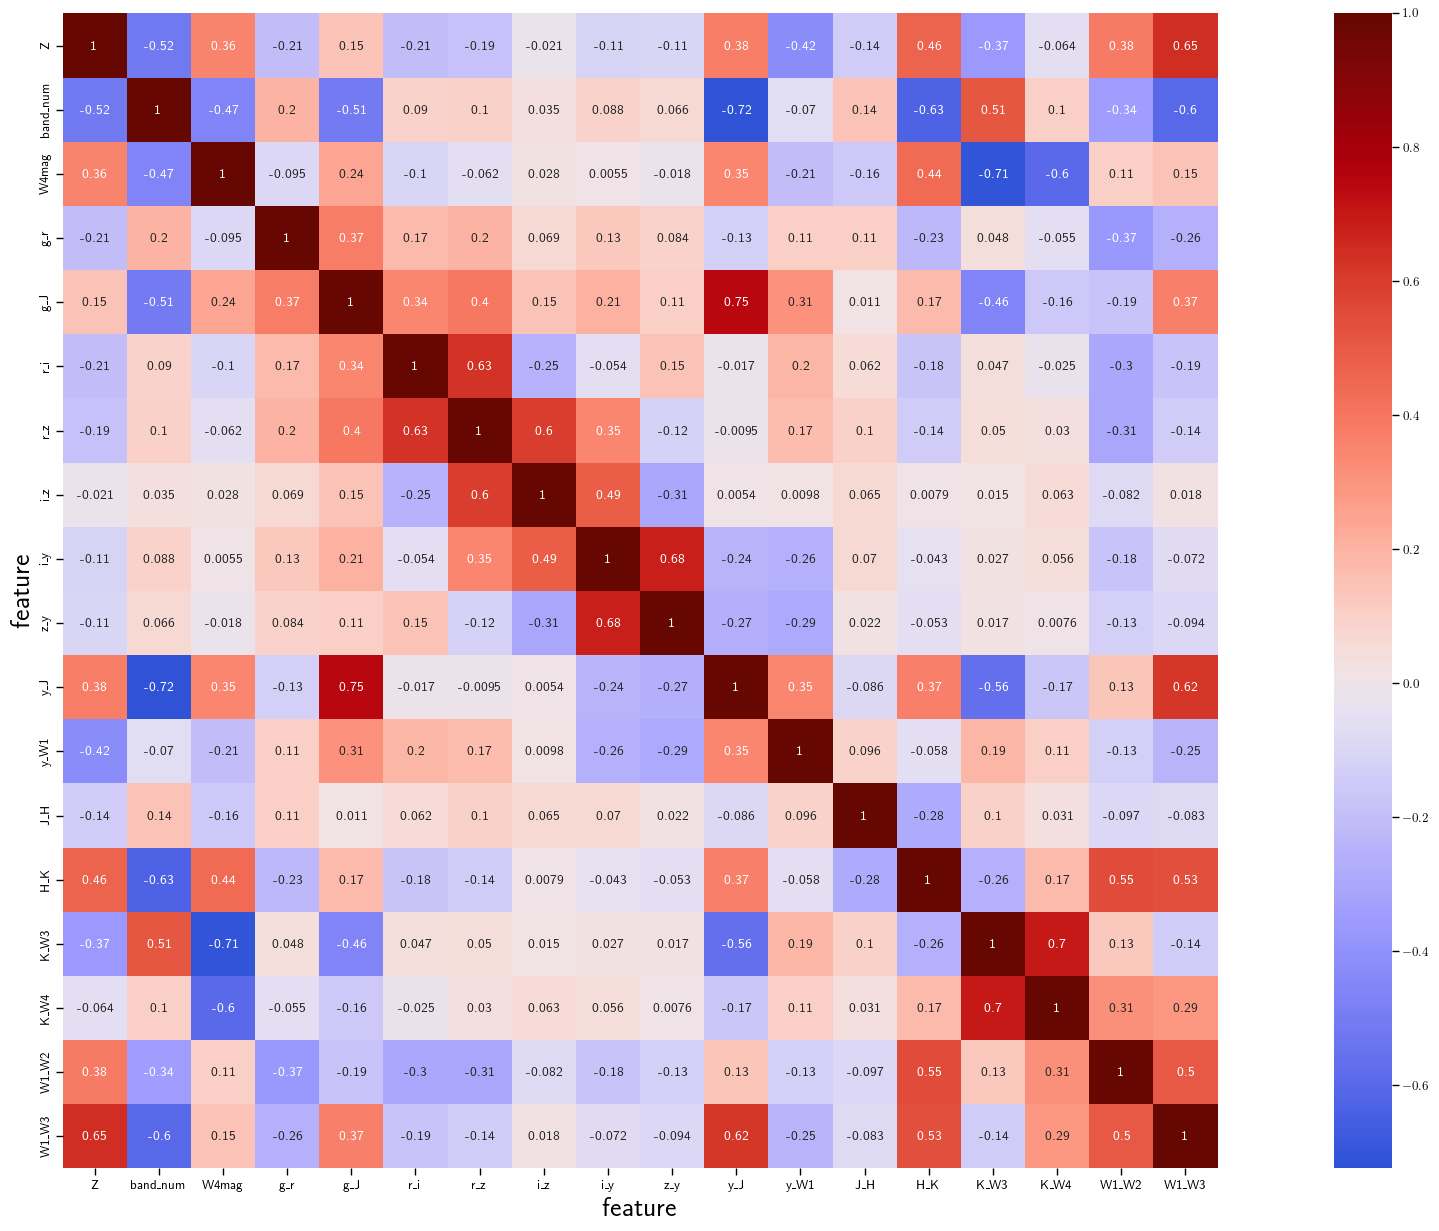

In [35]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [36]:
# norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [37]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [38]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
H_K       H_K         1.000000
band_num  y_J         0.464506
J_H       band_num    0.452722
K_W4      W4mag       0.443817
H_K       band_num    0.441330
Z         H_K         0.424689
K_W4      K_W3        0.372801
J_H       H_K         0.340979
W4mag     K_W3        0.334414
K_W3      K_W4        0.287378
y_J       band_num    0.277949
band_num  H_K         0.237936
K_W4      band_num    0.229686
K_W3      W4mag       0.226259
          y_J         0.215485
y_J       g_J         0.210588
band_num  Z           0.195269
W4mag     band_num    0.188854
band_num  W1_W3       0.188122
          g_J         0.187441
dtype: float64

In [39]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [40]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [41]:
list_drop_pps = []

In [42]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [43]:
list_drop_pps

[]

In [44]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [45]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [46]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0.195269,regression,True,mean absolute error,0.118016,0.094971,DecisionTreeRegressor()
1,H_K,Z,0.177755,regression,True,mean absolute error,0.118016,0.097038,DecisionTreeRegressor()
2,J_H,Z,0.170329,regression,True,mean absolute error,0.118016,0.097915,DecisionTreeRegressor()
3,W1_W3,Z,0.161930,regression,True,mean absolute error,0.118016,0.098906,DecisionTreeRegressor()
4,K_W4,Z,0.154275,regression,True,mean absolute error,0.118016,0.099809,DecisionTreeRegressor()
5,W4mag,Z,0.090479,regression,True,mean absolute error,0.118016,0.107338,DecisionTreeRegressor()
6,K_W3,Z,0.050436,regression,True,mean absolute error,0.118016,0.112064,DecisionTreeRegressor()
7,W1_W2,Z,0.037867,regression,True,mean absolute error,0.118016,0.113547,DecisionTreeRegressor()
8,g_r,Z,0.000000,regression,True,mean absolute error,0.118016,0.143283,DecisionTreeRegressor()
9,g_J,Z,0.000000,regression,True,mean absolute error,0.118016,0.152011,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [47]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
# final_feats.remove('J_H')       # After Boruta

In [48]:
feats_2_discard = list_drop_corr + list_drop_pps#  + ['J_H']

Boruta discards one feature.

In [50]:
exp_radio = pyr.setup(data                     = train_df,
                      test_data                = test_df,
                      target                   = target_feat,
                      session_id               = gv.seed,
                      silent                   = True,
                      feature_selection        = False,
                      feature_selection_method = 'boruta',
                      numeric_features         = final_feats,
                      ignore_features          = feats_2_discard,
                      transformation           = True,
                      transformation_method    = 'yeo-johnson',
                      n_jobs                   = 12,
                      normalize                = True,
                      normalize_method         = 'zscore',
                      use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(5312, 80)"
3,Missing Values,False
4,Numeric Features,17
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5312, 17)"


In [51]:
pyr.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'g_J', 'r_i', 'r_z', 'i_z', 'i_y', 'z_y',
       'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3'],
      dtype='object')

In [52]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [53]:
pyr.add_metric('s_mad',  'sigma_mad',    gf.sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   gf.sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      gf.sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', gf.sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   gf.outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7f3069f419d0>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [54]:
pyr.models(internal=True).loc['rf']['Tune Grid'].keys()

dict_keys(['n_estimators', 'max_depth', 'min_impurity_decrease', 'max_features', 'bootstrap', 'criterion', 'min_samples_split', 'min_samples_leaf'])

In [55]:
metric_2_opt          = 's_mad'
final_selection_reg   = ['rf', 'et', 'catboost', 'xgboost', 'gbr', 'dummy']  # knn discarded: no feature importances
initial_selection_reg = ['rf', 'et', 'gbr', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, dt)
n_models              = 5
top_model_z           = pyr.compare_models(n_select = n_models,
                                           include  = final_selection_reg,
                                           sort     = metric_2_opt)  # 1:15 hour for used_models_clf
# top_model_z           = pyr.compare_models(n_select=n_models, include=initial_selection_reg, sort=metric_2_opt)  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
rf,Random Forest Regressor,0.2570,0.1967,0.4413,0.7434,0.1772,0.3847,0.1884,0.0818,0.4413,0.2095,0.2159,0.6280
et,Extra Trees Regressor,0.2606,0.1952,0.4409,0.7450,0.1746,0.3967,0.2035,0.0904,0.4409,0.2005,0.2263,0.3690
catboost,CatBoost Regressor,0.2682,0.1814,0.4249,0.7634,0.1731,0.4939,0.2295,0.1091,0.4249,0.1978,0.2432,0.5680
xgboost,Extreme Gradient Boosting,0.2848,0.2108,0.4579,0.7249,0.1851,0.4959,0.2374,0.1110,0.4579,0.2147,0.2549,9.1820
gbr,Gradient Boosting Regressor,0.3126,0.2216,0.4701,0.7109,0.1921,0.6192,0.2929,0.1372,0.4701,0.2192,0.3165,0.1960
dummy,Dummy Regressor,0.7235,0.7664,0.8752,-0.0007,0.4010,3.0135,0.9991,0.4003,0.8752,0.5061,0.7208,0.0060


Thus, we select `rf` as meta learner. It has the best scores in sigma_mad, sigma_nmad and outlier fraction.  
These are the values we care the most about.

Thus, we stack the models.

In [56]:
base_models = top_model_z[1:]
meta_model  = top_model_z[0]

In [57]:
stacked_model_z = pyr.stack_models(estimator_list = base_models,
                                   meta_model     = meta_model,
                                   optimize       = metric_2_opt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2334,0.1631,0.4038,0.7761,0.1634,0.3557,0.1790,0.0786,0.4038,0.1930,0.1880
1,0.2156,0.1361,0.3689,0.8315,0.1471,0.2845,0.1695,0.0728,0.3689,0.1631,0.1729
2,0.2259,0.1538,0.3922,0.7905,0.1618,0.3290,0.1737,0.0745,0.3922,0.1971,0.1808
3,0.2066,0.1264,0.3556,0.8296,0.1447,0.2679,0.1558,0.0674,0.3556,0.1610,0.1507
4,0.2445,0.1677,0.4095,0.7940,0.1631,0.3616,0.1818,0.0815,0.4095,0.1945,0.2053
5,0.2533,0.1951,0.4417,0.7483,0.1842,0.4027,0.1879,0.0810,0.4417,0.2424,0.2072
6,0.2240,0.1489,0.3859,0.7865,0.1625,0.4109,0.1595,0.0699,0.3859,0.2076,0.1846
7,0.2342,0.1894,0.4353,0.7535,0.1696,0.3034,0.1450,0.0673,0.4353,0.2072,0.1864
8,0.2350,0.1771,0.4208,0.7778,0.1633,0.3476,0.1665,0.0708,0.4208,0.1796,0.1921


In [55]:
rf_tune_grid                 = pyr.models(internal=True).loc['rf']['Tune Grid']
rf_tune_grid['max_depth']    = [3, 4, 5, 6, 7, 8, 9, 10, 11]  # old = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
rf_tune_grid['max_features'] = [0.25, 0.33, 0.66]  # old = [1.0, 'sqrt', 'log2']

In [58]:
# tuned_z_reg = pyr.tune_model(estimator        = stacked_model_z,
#                              early_stopping   = True,
#                              optimize         = metric_2_opt,
#                              search_library   = 'tune-sklearn',
#                              search_algorithm = 'bayesian',
#                              choose_better    = True,
#                              custom_grid      = rf_tune_grid)  # 1h30
tuned_z_reg = pyr.tune_model(estimator        = stacked_model_z,
                             early_stopping   = True,
                             optimize         = metric_2_opt,
                             search_library   = 'tune-sklearn',
                             search_algorithm = 'bayesian',
                             choose_better    = True)  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2200,0.1475,0.3841,0.7974,0.1542,0.3160,0.1562,0.0698,0.3841,0.1735,0.1617
1,0.2144,0.1439,0.3793,0.8219,0.1481,0.2534,0.1464,0.0657,0.3793,0.1511,0.1635
2,0.2183,0.1496,0.3868,0.7962,0.1577,0.2943,0.1519,0.0637,0.3868,0.1843,0.1733
3,0.2009,0.1307,0.3616,0.8238,0.1398,0.2340,0.1478,0.0629,0.3616,0.1441,0.1337
4,0.2347,0.1567,0.3958,0.8076,0.1542,0.2944,0.1653,0.0717,0.3958,0.1749,0.1940
5,0.2465,0.2035,0.4511,0.7375,0.1823,0.3293,0.1699,0.0730,0.4511,0.2415,0.1827
6,0.2265,0.1556,0.3944,0.7770,0.1640,0.3780,0.1527,0.0726,0.3944,0.2105,0.1789
7,0.2208,0.1840,0.4290,0.7605,0.1631,0.2639,0.1334,0.0609,0.4290,0.1877,0.1751
8,0.2213,0.1734,0.4164,0.7825,0.1579,0.2877,0.1494,0.0656,0.4164,0.1665,0.1657


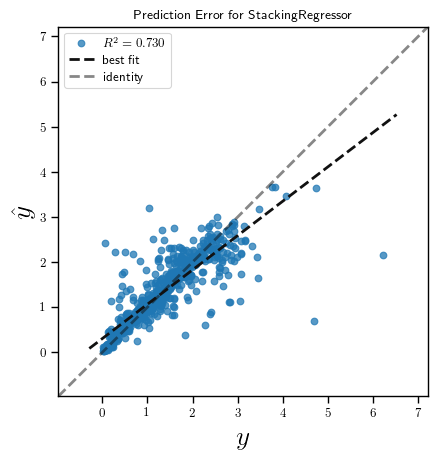

In [59]:
pyr.plot_model(tuned_z_reg, plot='error')

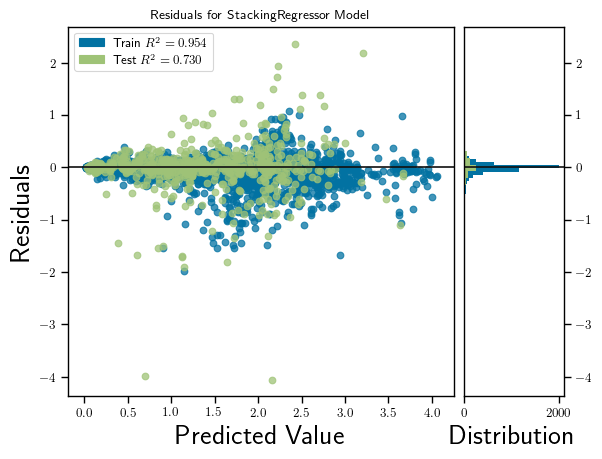

In [60]:
pyr.plot_model(tuned_z_reg, plot='residuals')

In [77]:
# pyr.plot_model(tuned_z_reg.final_estimator_, plot='feature_all')

In [61]:
pyr.plot_model(tuned_z_reg.final_estimator_, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,mae
max_depth,9
max_features,0.6346363645439446
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,3.221765456072098e-08
min_impurity_split,None
min_samples_leaf,5


In [62]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,mae
max_depth,9
max_features,0.6346363645439446
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,3.221765456072098e-08
min_impurity_split,None
min_samples_leaf,5


In [63]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [64]:
pyr.predict_model(tuned_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2389,0.2108,0.4592,0.7299,0.1706,0.3146,0.1484,0.0709,0.4592,0.1973,0.1824


,Z,Label
count,669.000000,669.000000
mean,1.298912,1.293366
std,0.884227,0.787171
min,0.021000,0.028650
25%,0.539000,0.626623
50%,1.262000,1.233840
75%,1.899000,2.002556
max,6.210000,3.666150


In [65]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2389,0.2108,0.4592,0.7299,0.1706,0.3146,0.1484,0.0709,0.4592,0.1973,0.1824


In [66]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

In [67]:
pyr.predict_model(final_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2389,0.2108,0.4592,0.7299,0.1706,0.3146,0.1484,0.0709,0.4592,0.1973,0.1824


,Z,Label
count,669.000000,669.000000
mean,1.298912,1.293366
std,0.884227,0.787171
min,0.021000,0.028650
25%,0.539000,0.626623
50%,1.262000,1.233840
75%,1.899000,2.002556
max,6.210000,3.666150


In [68]:
if save_model_flag:
    pyr.save_model(final_z_reg, gv.models_path + gv.full_z_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [50]:
if load_model_flag:
    final_z_reg = pyr.load_model(gv.models_path + gv.full_z_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [69]:
base_models_names = gf.get_base_estimators_names(final_z_reg)
base_models       = gf.get_base_estimators_models(final_z_reg)

In [70]:
print('Running data pre-processing:\n')
extended_data_z_df = gf.preprocess_data(final_z_reg, validation_df, base_models_names)

Running data pre-processing:



In [71]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_z_reg, extended_data_z_df)

In [72]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_z_df)

In [73]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [74]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for et...
Calculating for catboost...
Calculating for xgboost...
Calculating for gbr...


et             catboost              xgboost                  gbr  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      W1_W3  23.024472      y_W1  21.080109     W1_W3  31.150723     W1_W3   
1       y_W1  14.616392     W1_W3  17.553154       H_K  26.416338      y_W1   
2   band_num   9.997194     W1_W2  12.265704     W4mag   8.365820       H_K   
3      W4mag   9.127023       g_r   7.453357      y_W1   8.175259     W1_W2   
4      W1_W2   8.168476       r_z   7.020911     W1_W2   3.849434     W4mag   
5        H_K   5.896460       H_K   5.672702       y_J   2.785380       g_r   
6        g_r   4.865634       z_y   4.946705       r_z   2.629420  band_num   
7        y_J   3.738461       r_i   3.913014  band_num   2.404274       y_J   
8        r_z   3.537655  band_num   3.579159       z_y   2.305164       z_y   
9        r_i   3.127858       i_y   3.488016      K_W3   2.216144       r_z   
10       z_y   2.917925       i_z   3.282627       g_r   1.982902      K_W4   
11       g_J   2.869962       y_J   2.667476       J_H   1.939485       g_J   
12       i_y   2.569020      K_W3   2.111302       i_z   1.636457       r_i   
13       i_z   2.539099       g_J   1.916978       r_i   1.429799       i_z   
14      K_W3   1.861489      K_W4   1.597073       i_y   1.372853      K_W3   
15       J_H   0.608578     W4mag   1.086046       g_J   0.851707       J_H   
16      K_W4   0.534301       J_H   0.365667      K_W4   0.488843       i_y   

               
   Importance  
0   49.536533  
1   16.513416  
2    8.136582  
3    5.369716  
4    4.451499  
5    3.160189  
6    2.690543  
7    2.594525  
8    1.965388  
9    1.722923  
10   1.379999  
11   0.730203  
12   0.722314  
13   0.319066  
14   0.255508  
15   0.242920  
16   0.208677

In [75]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
coef_sorted_meta_df_copy_sum['Cumulative_sum'] = coef_sorted_meta_df_copy_sum.loc[:, 'Importance'].cumsum()
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance,Cumulative_sum
0,gbr,48.485001,48.485001
1,xgboost,28.712168,77.197169
2,catboost,4.550542,81.747711
3,et,3.622658,85.370369
4,g_r,2.337016,87.707385
5,W1_W2,1.795294,89.502679
6,r_i,1.774751,91.277430
7,i_z,1.541865,92.819296
8,H_K,1.524229,94.343525
9,z_y,1.054656,95.398181


In [77]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
    coef_sorted_comb_sum = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False)#.drop(index=base_models_names)
    coef_sorted_comb_sum['Cumulative_sum'] = coef_sorted_comb_sum.loc[:, 'Importance'].cumsum()
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Cumulative_sum,Importance
Feature,,
W1_W3,35.5722,35.5722
H_K,49.0979,13.5257
y_W1,61.7059,12.6079
W1_W2,68.0640,6.3581
W4mag,73.0483,4.9844
g_r,78.0023,4.9540
r_z,81.0206,3.0182
z_y,84.0208,3.0002
band_num,86.9170,2.8962


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W1_W3	35.572
H_K	13.526
y_W1	12.608
W1_W2	6.358
W4mag	4.984
g_r	4.954
r_z	3.018
z_y	3.000
band_num	2.896
r_i	2.827
y_J	2.784
i_z	2.408
g_J	1.215
i_y	1.162
K_W3	1.000
K_W4	0.925
J_H	0.762


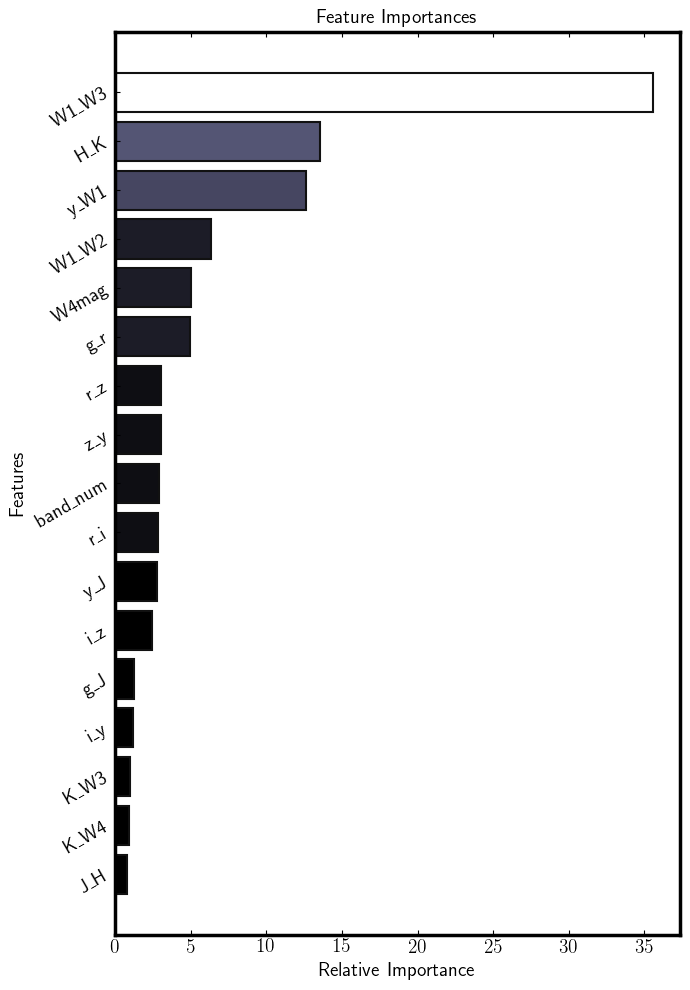

In [78]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_regression_z_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [79]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_z_reg, 'rf', 'regression')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,rf,et,catboost,xgboost,gbr
n_estimators,187,100.0000,NaN,100.0000,100.0000
max_depth,9,NaN,NaN,6.0000,3.0000
min_impurity_decrease,0.0000,0.0000,NaN,NaN,0.0000
max_features,0.6346,auto,NaN,NaN,None
bootstrap,False,False,NaN,NaN,NaN
criterion,mae,mse,NaN,NaN,NaN
min_samples_split,3,2.0000,NaN,NaN,2.0000
min_samples_leaf,5,1.0000,NaN,NaN,1.0000
learning_rate,NaN,NaN,0.0533,0.3000,0.1000
depth,NaN,NaN,6.0000,NaN,NaN


---

In [80]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 5,312
Size of test set is  669


In [81]:
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)
calib_prediction_reg      = pyr.predict_model(final_z_reg, data=calibration_df)
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0951,0.0354,0.1882,0.9538,0.0634,0.0898,0.0645,0.0298,0.1882,0.0608,0.0375


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2389,0.2108,0.4592,0.7299,0.1706,0.3146,0.1484,0.0709,0.4592,0.1973,0.1824


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1231,0.0667,0.2584,0.9137,0.0929,0.1298,0.0747,0.0344,0.2584,0.0972,0.0671


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2256,0.1671,0.4087,0.7959,0.1554,0.2572,0.1470,0.0686,0.4087,0.1579,0.1819


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2145,0.1508,0.3883,0.7986,0.1539,0.2719,0.1490,0.0638,0.3883,0.1851,0.1611


In [82]:
validation_prediction_reg.loc[:, [target_feat, 'Label']].describe()

,Z,Label
count,1695.000000,1695.000000
mean,1.336221,1.330902
std,0.865545,0.781876
min,0.006000,0.021545
25%,0.618000,0.704884
50%,1.281000,1.352126
75%,1.934500,1.953253
max,4.848000,4.007179


In [83]:
sigma_mad_train         = gf.sigma_mad(train_prediction_reg.loc[:, target_feat],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test          = gf.sigma_mad(test_prediction_reg.loc[:, target_feat],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_train_test    = gf.sigma_mad(train_test_prediction_reg.loc[:, target_feat],    train_test_prediction_reg.loc[:, 'Label'])
sigma_mad_calib         = gf.sigma_mad(calib_prediction_reg.loc[:, target_feat],         calib_prediction_reg.loc[:, 'Label'])
sigma_mad_valid         = gf.sigma_mad(validation_prediction_reg.loc[:, target_feat],    validation_prediction_reg.loc[:, 'Label'])

In [84]:
sigma_nmad_train        = gf.sigma_nmad(train_prediction_reg.loc[:, target_feat],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test         = gf.sigma_nmad(test_prediction_reg.loc[:, target_feat],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_train_test   = gf.sigma_nmad(train_test_prediction_reg.loc[:, target_feat],   train_test_prediction_reg.loc[:, 'Label'])
sigma_nmad_calib        = gf.sigma_nmad(calib_prediction_reg.loc[:, target_feat],        calib_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid        = gf.sigma_nmad(validation_prediction_reg.loc[:, target_feat],   validation_prediction_reg.loc[:, 'Label'])

In [85]:
sigma_z_train           = gf.sigma_z(train_prediction_reg.loc[:, target_feat],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test            = gf.sigma_z(test_prediction_reg.loc[:, target_feat],            test_prediction_reg.loc[:, 'Label'])
sigma_z_train_test      = gf.sigma_z(train_test_prediction_reg.loc[:, target_feat],      train_test_prediction_reg.loc[:, 'Label'])
sigma_z_calib           = gf.sigma_z(calib_prediction_reg.loc[:, target_feat],           calib_prediction_reg.loc[:, 'Label'])
sigma_z_valid           = gf.sigma_z(validation_prediction_reg.loc[:, target_feat],      validation_prediction_reg.loc[:, 'Label'])

In [86]:
sigma_z_norm_train      = gf.sigma_z_norm(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test       = gf.sigma_z_norm(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_train_test = gf.sigma_z_norm(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_calib      = gf.sigma_z_norm(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid      = gf.sigma_z_norm(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

In [87]:
out_frac_train          = gf.outlier_frac(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
out_frac_test           = gf.outlier_frac(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
out_frac_train_test     = gf.outlier_frac(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
out_frac_calib          = gf.outlier_frac(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
out_frac_valid          = gf.outlier_frac(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

Display metrics as DataFrame

In [88]:
metrics_z = np.array([[len(train_prediction_reg),      sigma_mad_train,      sigma_nmad_train,\
                       sigma_z_train,      sigma_z_norm_train,      out_frac_train],\
                      [len(test_prediction_reg),       sigma_mad_test,       sigma_nmad_test,\
                       sigma_z_test,       sigma_z_norm_test,       out_frac_test],\
                      [len(train_test_prediction_reg), sigma_mad_train_test, sigma_nmad_train_test,\
                       sigma_z_train_test, sigma_z_norm_train_test, out_frac_train_test],\
                      [len(calib_prediction_reg),      sigma_mad_calib,      sigma_nmad_calib,\
                       sigma_z_calib,      sigma_z_norm_calib,      out_frac_calib],\
                      [len(validation_prediction_reg), sigma_mad_valid,      sigma_nmad_valid,\
                       sigma_z_valid,      sigma_z_norm_valid,      out_frac_valid]])

In [89]:
metrics_z_df = pd.DataFrame(data=metrics_z, index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])

In [90]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
    display(metrics_z_df)

,Sample,σ MAD,σ NMAD,σ z,σ z N,η
Train,5312,0.0645,0.0298,0.1882,0.0608,0.0375
Test,669,0.1484,0.0709,0.4592,0.1973,0.1824
Train+Test,6679,0.0747,0.0344,0.2584,0.0972,0.0671
Calibration,698,0.1470,0.0686,0.4087,0.1579,0.1819
Validation,1695,0.1490,0.0638,0.3883,0.1851,0.1611


Mean biases per sub-set.

In [91]:
res_z_train      = (train_prediction_reg.loc[:, 'Label']      -
                    train_prediction_reg.loc[:, target_feat])      / (1 + train_prediction_reg.loc[:, target_feat])
res_z_test       = (test_prediction_reg.loc[:, 'Label']       -
                    test_prediction_reg.loc[:, target_feat])       / (1 + test_prediction_reg.loc[:, target_feat])
res_z_train_test = (train_test_prediction_reg.loc[:, 'Label'] -
                    train_test_prediction_reg.loc[:, target_feat]) / (1 + train_test_prediction_reg.loc[:, target_feat])
res_z_calib      = (calib_prediction_reg.loc[:, 'Label']      -
                    calib_prediction_reg.loc[:, target_feat])      / (1 + calib_prediction_reg.loc[:, target_feat])
res_z_validation = (validation_prediction_reg.loc[:, 'Label'] -
                    validation_prediction_reg.loc[:, target_feat]) / (1 + validation_prediction_reg.loc[:, target_feat])

In [92]:
stats_res_z  = np.array([[len(train_prediction_reg),      np.nanmean(res_z_train),      np.nanstd(res_z_train)],
                         [len(test_prediction_reg),       np.nanmean(res_z_test),       np.nanstd(res_z_test)], 
                         [len(train_test_prediction_reg), np.nanmean(res_z_train_test), np.nanstd(res_z_train_test)],
                         [len(calib_prediction_reg),      np.nanmean(res_z_calib),      np.nanstd(res_z_calib)],
                         [len(validation_prediction_reg), np.nanmean(res_z_validation), np.nanstd(res_z_validation)]])

In [93]:
stats_res_z_df = pd.DataFrame(data=stats_res_z, index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                            columns=['Sample', 'Mean \u0394 z / (1 + z)', 'Std. dev. \u0394 z / (1 + z)'])

In [94]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    stats_res_z_df.loc[:, 'Sample'] = stats_res_z_df.loc[:, 'Sample'].astype(int)
    display(stats_res_z_df)

,Sample,Mean Δ z / (1 + z),Std. dev. Δ z / (1 + z)
Train,5312,-0.0069,0.0604
Test,669,0.0238,0.1958
Train+Test,6679,-0.0011,0.0972
Calibration,698,0.0186,0.1568
Validation,1695,0.0207,0.1840


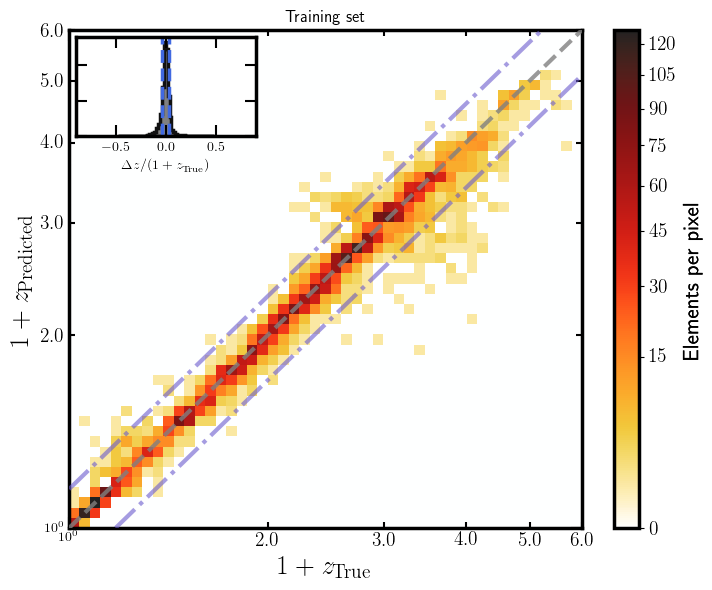

In [95]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(train_prediction_reg.loc[:, target_feat], train_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Training set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_train_redshift_04.pdf', bbox_inches='tight')
plt.show()

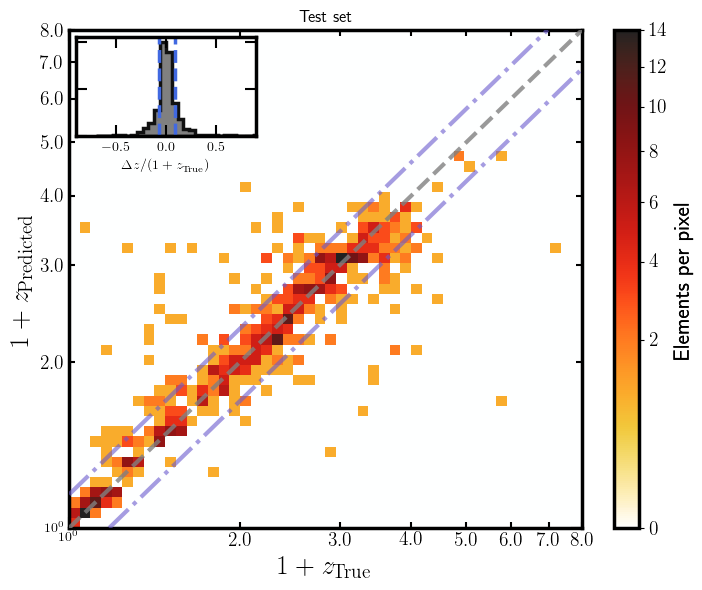

In [96]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(test_prediction_reg.loc[:, target_feat], test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_test_redshift_04.pdf', bbox_inches='tight')
plt.show()

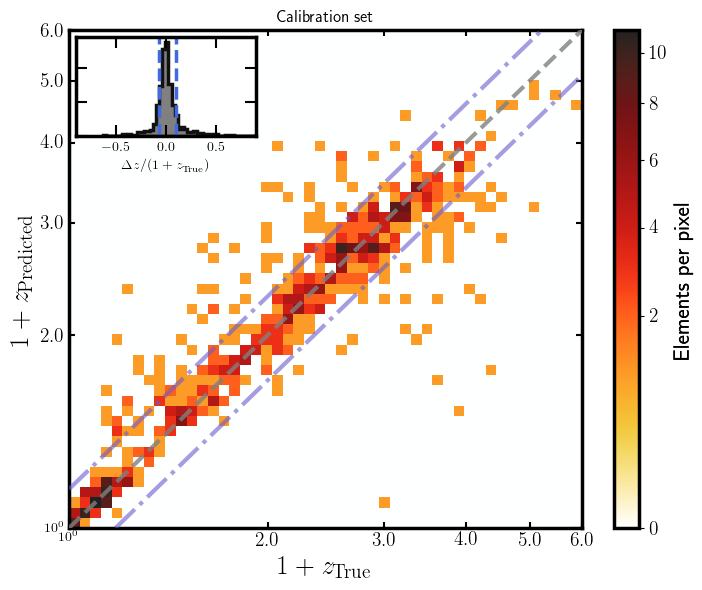

In [97]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(calib_prediction_reg.loc[:, target_feat], calib_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Calibration set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_calibration_redshift_04.pdf', bbox_inches='tight')
plt.show()

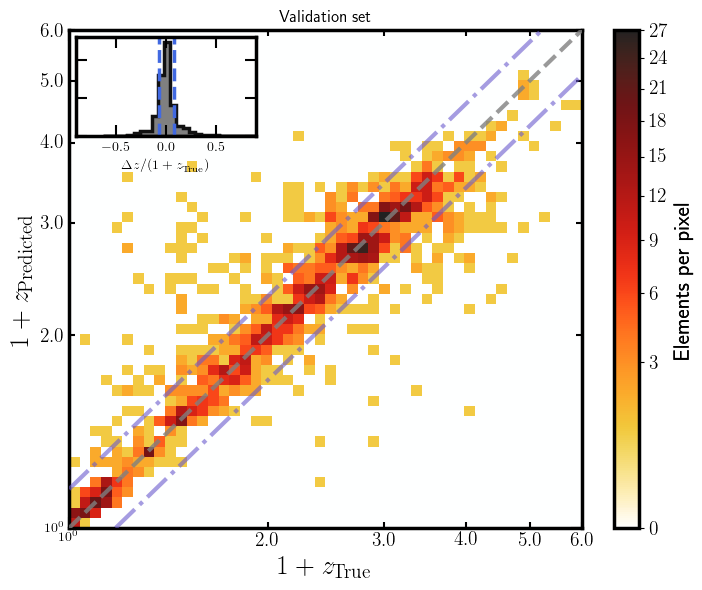

In [98]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Validation set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_validation_redshift_04.pdf', bbox_inches='tight')
plt.show()

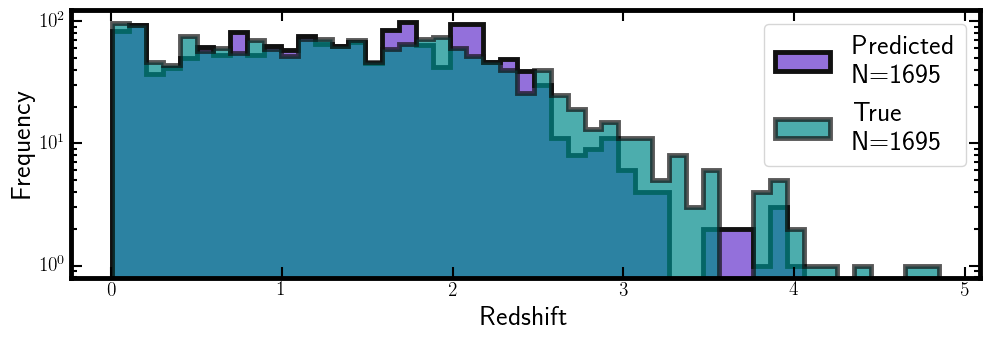

In [99]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, target_feat], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_true_predicted_z_04.pdf')
plt.show()

---

#### Redshift threshold

In order to understand where (in redshift) the predictions are far off from real values, we can use the evolution of the outlier fraction to obtain the point where that happens.

In [100]:
n_elems        = 50
z_range_lin    = np.linspace(0, np.nanmax(train_test_prediction_reg.loc[:, target_feat]), n_elems)
z_range_log    = np.logspace(np.log10(np.abs(np.nanmin(train_test_prediction_reg.loc[:, target_feat]))),\
                          np.log10(np.abs(np.nanmax(train_test_prediction_reg.loc[:, target_feat]))), n_elems)
z_range_lg_inv = np.abs(np.abs(np.nanmax(train_test_prediction_reg.loc[:, target_feat]))) - z_range_log

In [101]:
train_test_prediction_reg = train_test_prediction_reg.rename(columns={'Label': 'pred_Z'})

In [102]:
s_MAD_z_z_lin          = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_lin        = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_lin      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.outlier_frac,   target_feat,            'pred_Z')

In [103]:
s_MAD_z_z_log          = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_log        = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_log      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.outlier_frac,   target_feat,            'pred_Z')

In [104]:
s_MAD_z_z_log_inv      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_log_inv    = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_log_inv  = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.outlier_frac,   target_feat,            'pred_Z')

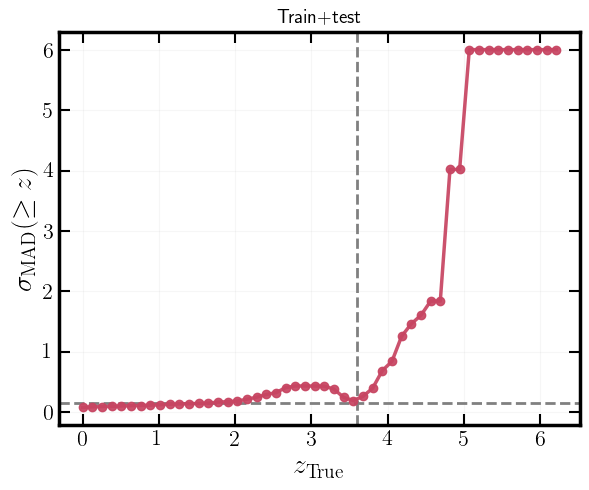

In [105]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_MAD_z_z_lin, '\sigma_{MAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'sigma_mad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

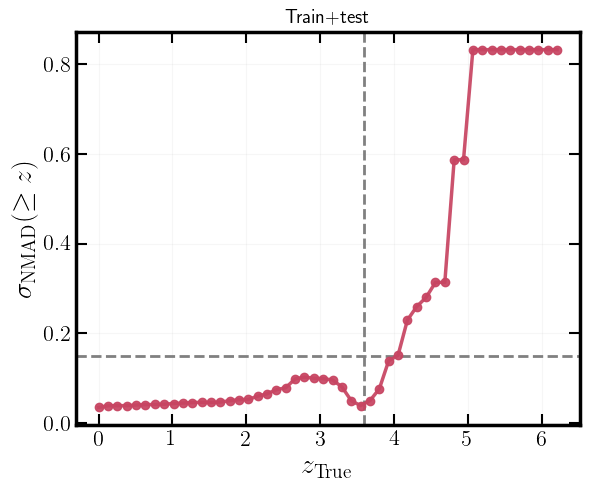

In [106]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_NMAD_z_z_lin, '\sigma_{NMAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'sigma_nmad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

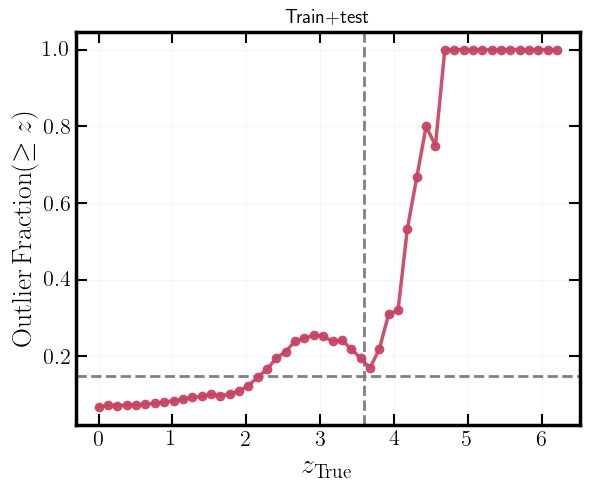

In [107]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, out_fr_z_z_lin, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

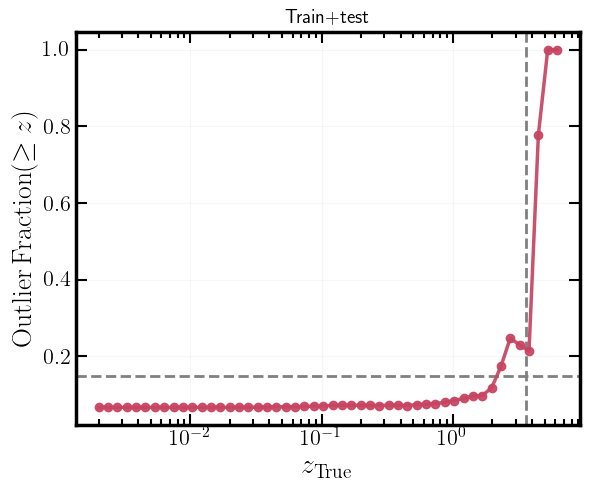

In [108]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='log', yscale='linear')
plot_metric_over_z(z_range_log, out_fr_z_z_log, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

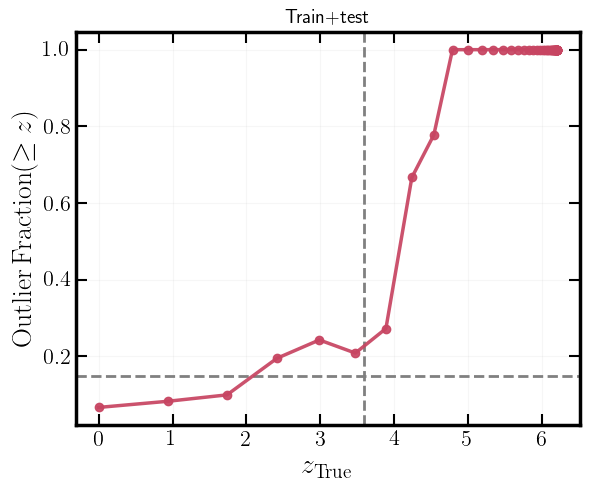

In [109]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lg_inv, out_fr_z_z_log_inv, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_inv_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()